0: 59411.98194330931
100: -2795.238077700138
200: -48867.9827670455
300: -77024.87719339132
400: -102800.92181509733
500: -119796.44599467516
600: -141646.93696522713
700: -139863.83195769787
800: -142780.82084470987
900: -171399.48236489296


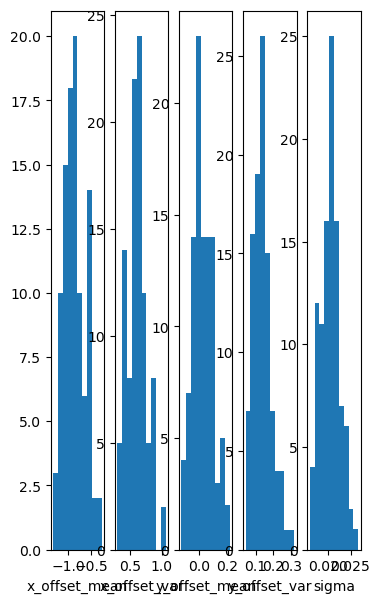

In [6]:
import matplotlib.pyplot as plt
import pyro
import torch
from pyro.distributions import Uniform, Normal, Exponential
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.autoguide import AutoDelta, AutoNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.clear_param_store()


def mapping(
        xcoords,
        ycoords,
        x_offset,
        y_offset
):
    return torch.exp(-(xcoords - x_offset) ** 2) * torch.exp(-(ycoords - y_offset) ** 2)


# create a generative model that produces signals with random offsets
def model(xcoords, ycoords, data=None):
    x_offset_mean = pyro.sample(
        "x_offset_mean", Uniform(-2.0, 2.0)
    )
    x_offset_var = pyro.sample(
        "x_offset_var", Uniform(0.0, 2.0)
    )

    y_offset_mean = pyro.sample(
        "y_offset_mean", Uniform(-2.0, 2.0)
    )
    y_offset_var = pyro.sample(
        "y_offset_var", Uniform(0.0, 2.0)
    )

    sigma = pyro.sample(
        "sigma", Exponential(100.0)
    )

    d_size = 6 if data is None else data.shape[-1]

    with pyro.plate("shots", d_size):
        x_offset = pyro.sample(
            "x_offset", Normal(x_offset_mean, x_offset_var)
        )
        y_offset = pyro.sample(
            "y_offset", Normal(y_offset_mean, y_offset_var)
        )
        with pyro.plate("xbins", xcoords.shape[-1]):
            with pyro.plate("ybins", xcoords.shape[-2]):
                mean = mapping(
                    xcoords.unsqueeze(-1), ycoords.unsqueeze(-1),
                    x_offset, y_offset)

                return pyro.sample(
                    "obs", Normal(mean, sigma), obs=data
                )


# test generator
test_x = torch.linspace(-5, 5, 100)
test_y = torch.linspace(-5, 5, 100)
xx = torch.meshgrid([test_x, test_y])

samples = model(*xx)

# create data samples -- corrupt with noise
n_samples = 6
xoffset = Normal(torch.tensor(-1.0), torch.tensor(0.75)).rsample([n_samples])
yoffset = Normal(torch.tensor(0.0), torch.tensor(0.1)).rsample([n_samples])
y = mapping(xx[0].unsqueeze(-1), xx[1].unsqueeze(-1), xoffset, yoffset)
y += torch.randn(y.shape) * 0.01

# plt.show()

pyro.render_model(model, model_args=(*xx, y), filename="../model_2d.png")

# do SVI
guide = AutoNormal(model)
num_steps = 1000
initial_lr = 0.01
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(num_steps):
    loss = svi.step(*xx, y)
    losses.append(loss)

    if step % 100 == 0:
        print(f"{step}: {loss}")  # : {dict(pyro.get_param_store())}")

# make predictions
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100)
svi_samples = predictive(*xx, data=None)

# plot posterior samples



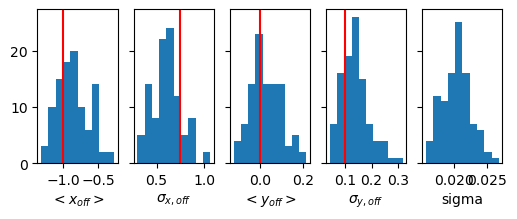

In [26]:
params = ["x_offset_mean", "x_offset_var", "y_offset_mean", "y_offset_var", "sigma"]
fig, ax = plt.subplots(1, len(params),sharey="all")
fig.set_size_inches(6,2)
for i, name in enumerate(params):
    ax[i].hist(svi_samples[name].flatten().detach().numpy())
    ax[i].set_xlabel(name)

ax[0].set_xlabel(r"$<x_{off}>$")
ax[0].axvline(-1.0,c="red")

ax[1].set_xlabel(r"$\sigma_{x,off}$")
ax[1].axvline(0.75,c="red")

ax[2].set_xlabel(r"$<y_{off}>$")
ax[2].axvline(0.0,c="red")

ax[3].set_xlabel(r"$\sigma_{y,off}$")
ax[3].axvline(0.1,c="red")

fig.savefig("jitter_result.svg")

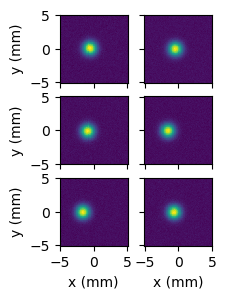

In [25]:
nimgs = y.shape[-1]
fig2,ax2 = plt.subplots(3,2,sharex="all",sharey="all")
fig2.set_size_inches(2,3)
for i in range(nimgs):
    ax2.flatten()[i].pcolor(*xx, y[...,i],rasterized=True)
    ax2.flatten()[i].set_aspect("equal")

for a in ax2[:,0]:
    a.set_ylabel("y (mm)")

for a in ax2[-1,:]:
    a.set_xlabel("x (mm)")

fig2.savefig("jitter_data.svg")